The notebook presents three models for digit recognition.

*   A fully-connected network
*   A convolutional neural network
*   A graph neural network

It was compiled from different sources. See for example, https://github.com/bknyaz/examples/blob/master/fc_vs_graph_train.py and https://github.com/DebasmitaGhose/PyTorch_Graph_Neural_Network_MNIST for more details

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

import numpy as np
from scipy.spatial.distance import cdist

In [ ]:
import argparse

parser = argparse.ArgumentParser(description='PyTorch MNIST Example')

parser.add_argument('--model', type=str, default='graph', choices=['fc', 'graph', 'conv'],
                    help='model to use for training (default: fc)')
parser.add_argument('--batch-size', type=int, default=64,
                    help='input batch size for training (default: 64)')
parser.add_argument('--test-batch-size', type=int, default=1000,
                    help='input batch size for testing (default: 1000)')
parser.add_argument('--epochs', type=int, default=10,
                    help='number of epochs to train (default: 10)')
parser.add_argument('--lr', type=float, default=0.001,
                    help='learning rate (default: 0.001)')
parser.add_argument('--pred_edge', action='store_true', default=False,
                    help='predict edges instead of using predefined ones')
parser.add_argument('--seed', type=int, default=1,
                    help='random seed (default: 1)')
parser.add_argument('--log-interval', type=int, default=200,
                    help='how many batches to wait before logging training status')
parser.add_argument('--save-model', action='store_true', default=True,
                    help='to save the current model')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

args = parser.parse_args(args=[]) # https://stackoverflow.com/a/76397269


'''
try:
    args = parser.parse_args()
except SystemExit:
    # Provide default values if parse_args fails
    args = argparse.Namespace(model='graph', batch_size=64, test_batch_size=1000,
                              epochs=10, lr=0.001, pred_edge=False, seed=1,
                              log_interval=200)
'''

print(args)

cpu
Namespace(model='graph', batch_size=64, test_batch_size=1000, epochs=10, lr=0.001, pred_edge=False, seed=1, log_interval=200, save_model=True)


# Dataset

In [ ]:
from torchvision import datasets, transforms

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('/content', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])), batch_size=args.batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('/content', train=False, transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))
        ])),
        batch_size=args.test_batch_size, shuffle=False)

100%|██████████| 9.91M/9.91M [00:00<00:00, 38.2MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.22MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 10.3MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 4.66MB/s]


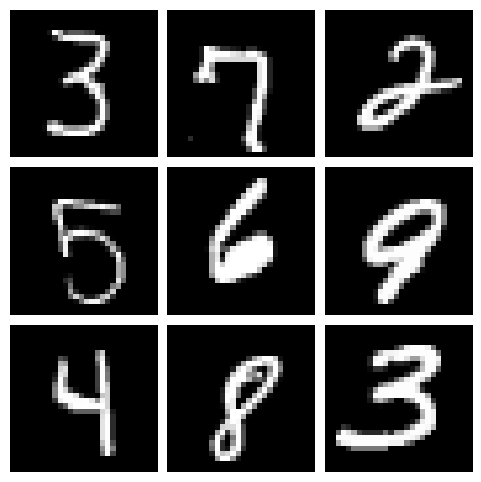

In [ ]:
from mpl_toolkits.axes_grid1 import ImageGrid

dataiter = iter(train_loader)
batch = next(dataiter)
target_images = batch[0]

num_samples = 9
sample_images = [target_images[i,0] for i in range(num_samples)]

fig = plt.figure(figsize=(6, 6))
grid = ImageGrid(fig, 111, nrows_ncols=(3, 3), axes_pad=0.1)

for ax, im in zip(grid, sample_images):
    #print(im.shape)
    ax.imshow(im, cmap='gray')
    ax.axis('off')

plt.show()

In [ ]:
target_images.size()

torch.Size([64, 1, 28, 28])

torch.Size([28, 28])


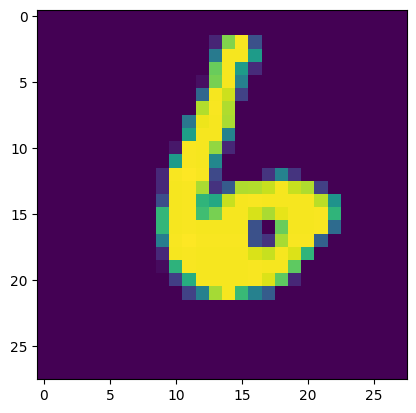

In [ ]:
print(sample_images[0].shape)

img = sample_images[0]
imgplot = plt.imshow(img)

Below are some cells to enable a detailed exploration of some portions of the code

In [ ]:
B = img.size(0)
B

28

In [ ]:
N = B ** 2
N

784

In [ ]:
print(img)

In [ ]:
img.shape

torch.Size([28, 28])

In [ ]:
print(img.view(img.size(0), -1))

In [ ]:
u = 3
print(np.arange(u))
print(np.meshgrid(np.arange(u), np.arange(u)))
col, row = np.meshgrid(np.arange(u), np.arange(u))
print(col)
print(row)
plt.plot(col, row, marker='o', color='k', linestyle='none')
plt.show()
coord = np.stack((col, row), axis=2).reshape(-1, 2)
print(coord)

In [ ]:
import imageio  # to save GIFs
import matplotlib as mpl
import cv2

img_size = 28
col, row = np.meshgrid(np.arange(img_size), np.arange(img_size))
coord = np.stack((col, row), axis=2).reshape(-1, 2) / img_size
dist = cdist(coord, coord)  # see figure below on the left
sigma = 0.2 * np.pi  # width of a Gaussian
A = np.exp(- dist ** 2 / sigma ** 2)  # see figure below in the middle

print(A, A.shape)
plt.plot(dist)
plt.show()

scale = 4
img_list = []
cmap = mpl.cm.get_cmap('viridis')
for i in np.arange(0, img_size, 4):  # for every row with step 4
    for j in np.arange(0, img_size, 4):  # for every col with step 4
        k = i*img_size + j
        img = A[k, :].reshape(img_size, img_size)
        img = (img - img.min()) / (img.max() - img.min())
        img = cmap(img)
        img[i, j] = np.array([1., 0, 0, 0])  # add the red dot
        img = cv2.resize(img, (img_size*scale, img_size*scale))
        img_list.append((img * 255).astype(np.uint8))
imageio.mimsave('filter.gif', img_list, format='GIF', duration=0.2)
#coord = (coord - np.mean(coord, axis=0)) / (np.std(coord, axis=0) + 1e-5)
#coord = torch.from_numpy(coord).float()  # 784,2
#coord = torch.cat((coord.unsqueeze(0).repeat(N, 1,  1), coord.unsqueeze(1).repeat(1, N, 1)), dim=2)

# Models

In [ ]:
class LinearNet(nn.Module):
    def __init__(self, input_size=784, num_classes=10):
        super(LinearNet, self).__init__()
        #self.fc = nn.Linear(784, 10, bias=False)
        self.layer1 = nn.Linear(input_size, num_classes)
        #self.relu = nn.ReLU()
        #self.layer2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        output = self.layer1(x)
        #output = self.relu(output)
        #output = self.layer2(output)
        return output
        #return self.fc(x.view(x.size(0), -1))

In [ ]:
# https://github.com/pytorch/examples/blob/main/mnist/main.py
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv = nn.Conv2d(1, 10, 28, stride=1, padding=14)
        self.fc = nn.Linear(4 * 4 * 10, 10, bias=False)

    def forward(self, x):
        x = F.relu(self.conv(x))
        x = F.max_pool2d(x, 7)
        return self.fc(x.view(x.size(0), -1))

In [ ]:
class GraphNet(nn.Module):
    def __init__(self, img_size=28, pred_edge=False):
        super(GraphNet, self).__init__()
        self.pred_edge = pred_edge
        N = img_size * img_size
        self.fc = nn.Linear(N, 10, bias=False)
        if pred_edge:
            col, row = np.meshgrid(np.arange(img_size), np.arange(img_size))
            coord = np.stack((col, row), axis=2).reshape(-1, 2)
            coord = (coord - np.mean(coord, axis=0)) / (np.std(coord, axis=0) + 1e-5)
            coord = torch.from_numpy(coord).float()  # 784,2
            coord = torch.cat((coord.unsqueeze(0).repeat(N, 1,  1),
                                    coord.unsqueeze(1).repeat(1, N, 1)), dim=2)
            #coord = torch.abs(coord[:, :, [0, 1]] - coord[:, :, [2, 3]])
            self.pred_edge_fc = nn.Sequential(nn.Linear(4, 64),
                                              nn.ReLU(),
                                              nn.Linear(64, 1),
                                              nn.Tanh())
            self.register_buffer('coord', coord)
        else:
            # precompute adjacency matrix before training
            A = self.precompute_adjacency_images(img_size)
            self.register_buffer('A', A)


    @staticmethod
    def precompute_adjacency_images(img_size):
        col, row = np.meshgrid(np.arange(img_size), np.arange(img_size))
        coord = np.stack((col, row), axis=2).reshape(-1, 2) / img_size
        dist = cdist(coord, coord)
        sigma = 0.05 * np.pi

        # Below, I forgot to square dist to make it a Gaussian (not sure how important it can be for final results)
        A = np.exp(- dist / sigma ** 2)
        print('WARNING: try squaring the dist to make it a Gaussian')

        A[A < 0.01] = 0
        A = torch.from_numpy(A).float()

        # Normalization as per (Kipf & Welling, ICLR 2017)
        D = A.sum(1)  # nodes degree (N,)
        D_hat = (D + 1e-5) ** (-0.5)
        A_hat = D_hat.view(-1, 1) * A * D_hat.view(1, -1)  # N,N

        # Some additional trick I found to be useful
        A_hat[A_hat > 0.0001] = A_hat[A_hat > 0.0001] - 0.2

        #print(A_hat[:10, :10])
        return A_hat

    def forward(self, x):
        B = x.size(0)
        if self.pred_edge:
            self.A = self.pred_edge_fc(self.coord).squeeze()

        avg_neighbor_features = (torch.bmm(self.A.unsqueeze(0).expand(B, -1, -1),
                                 x.view(B, -1, 1)).view(B, -1))
        return self.fc(avg_neighbor_features)

# Training

In [ ]:
def train(args, model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                       100. * batch_idx / len(train_loader), loss.item()))
    if args.save_model:
        path = "my_mnist_model_"+args.model+".pt"
        torch.save(model.state_dict(), path)

def test(args, model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print(
        '\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            test_loss, correct, len(test_loader.dataset),
            100. * correct / len(test_loader.dataset)))

In [ ]:
if args.model == 'fc':
    assert not args.pred_edge, "this flag is meant for graphs"
    model = LinearNet()
elif args.model == 'graph':
    model = GraphNet(pred_edge=args.pred_edge)
elif args.model == 'conv':
    model = ConvNet()
else:
    raise NotImplementedError(args.model)
model.to(device)
print(model)
optimizer = optim.SGD(model.parameters(), lr=args.lr, weight_decay=1e-1 if args.model == 'conv' else 1e-4)
print('number of trainable parameters: %d' %
      np.sum([np.prod(p.size()) if p.requires_grad else 0 for p in model.parameters()]))

for epoch in range(1, args.epochs + 1):
    train(args, model, device, train_loader, optimizer, epoch)
    test(args, model, device, test_loader)

GraphNet(
  (fc): Linear(in_features=784, out_features=10, bias=False)
)
number of trainable parameters: 7840
Train Epoch: 1 [0/60000 (0%)]	Loss: 3.142399
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.494557
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.287027
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.630468
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.455204

Test set: Average loss: 0.3861, Accuracy: 8854/10000 (89%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.468961
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.286332
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.262297
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.360496
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.304889

Test set: Average loss: 0.3472, Accuracy: 8991/10000 (90%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.277235
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.294683
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.304465
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.249169
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.315438

Test set: Average loss: 0.3359, 

# Testing

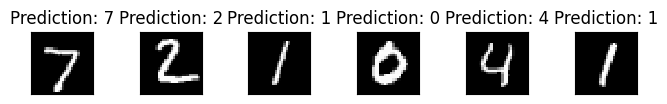

In [ ]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
output = model(example_data)

#fig = plt.figure()
for i in range(6):
  plt.subplot(1,6,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Prediction: {}".format(output.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])
#fig